In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers

from keras.preprocessing import sequence
from tensorflow.keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import add
from keras.applications.resnet import ResNet152
from keras.applications.resnet import preprocess_input
from keras.models import Model
#from keras.utils import to_categorical

In [2]:
! pip install datasets transformers[sentencepiece]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 9.7 MB/s 
     |████████████████████████████████| 5.3 MB 51.4 MB/s 
     |████████████████████████████████| 115 kB 58.2 MB/s 
     |████████████████████████████████| 212 kB 58.1 MB/s 
     |████████████████████████████████| 163 kB 47.4 MB/s 
     |████████████████████████████████| 127 kB 52.9 MB/s 
     |████████████████████████████████| 115 kB 56.6 MB/s 
     |████████████████████████████████| 7.6 MB 48.8 MB/s 
     |████████████████████████████████| 1.3 MB 62.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [3]:
! pip install nltk rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=fafc9f0eb1fab66500f646d0472a727ddba2b17898d6c822b999888a07bad7e1
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge-score


In [4]:
from datasets import load_metric


In [5]:
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

In [6]:
#from keras.optimizers import Adam
from keras.optimizers import adam_v2

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
token_path = '/content/drive/MyDrive/Flickr Dataset/Flickr8k_Dataset (1)/Flickr8k_text/Flickr8k.token.txt'
train_images_path = '/content/drive/MyDrive/Flickr Dataset/Flickr8k_Dataset (1)/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = '/content/drive/MyDrive/Flickr Dataset/Flickr8k_Dataset (1)/Flickr8k_text/Flickr_8k.testImages2.txt'
images_path = '/content/drive/MyDrive/Flickr Dataset/Flickr8k_Dataset (1)/Flicker8k_Dataset/'
glove_path = '/content/drive/MyDrive/Flickr Dataset/Flickr8k_Dataset (1)/glove.6B/'

doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [9]:
os. getcwd() 

'/content'

In [10]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

In [11]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

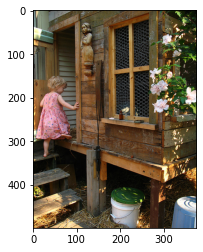

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']

In [12]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

In [13]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


In [14]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [15]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [16]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

In [17]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

In [18]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [19]:
word_count_threshold = 7
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 2064


In [20]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [21]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


In [22]:
###GLOVE Embedding
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [23]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [24]:
model = ResNet152(weights='imagenet')

242900224/242900224 [==============================] - 3s 0us/step


In [25]:
model_new = Model(model.input, model.layers[-2].output)

In [26]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [27]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 33ms/step


In [28]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 200)      413000      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [29]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [30]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ["accuracy"])

In [31]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [32]:
epochs = 20
batch_size = 128
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/20
46/46 [==============================] - 26s 463ms/step - loss: 5.3090 - accuracy: 0.1555
Epoch 2/20
46/46 [==============================] - 22s 477ms/step - loss: 4.3720 - accuracy: 0.2388
Epoch 3/20
46/46 [==============================] - 21s 464ms/step - loss: 3.7918 - accuracy: 0.2895
Epoch 4/20
46/46 [==============================] - 21s 463ms/step - loss: 3.5006 - accuracy: 0.3146
Epoch 5/20
46/46 [==============================] - 23s 500ms/step - loss: 3.3238 - accuracy: 0.3303
Epoch 6/20
46/46 [==============================] - 21s 461ms/step - loss: 3.1928 - accuracy: 0.3428
Epoch 7/20
46/46 [==============================] - 21s 456ms/step - loss: 3.0878 - accuracy: 0.3540
Epoch 8/20
46/46 [==============================] - 21s 453ms/step - loss: 3.0021 - accuracy: 0.3627
Epoch 9/20
46/46 [==============================] - 21s 453ms/step - loss: 2.9262 - accuracy: 0.3706
Epoch 10/20
46/46 [==============================] - 21s 448ms/step - loss: 2.8616 - accura

In [33]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [34]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

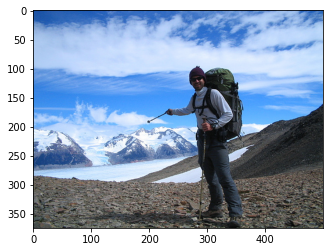

Greedy Search: a man in a yellow shirt is standing on a mountaintop with a man in a blue hat
Beam Search, K = 3: a man stands on a mountaintop overlooking a mountain
Beam Search, K = 5: a man in a yellow jacket is standing in front of a group of people
Beam Search, K = 7: a man is standing on a mountaintop with his arms in front of them
Beam Search, K = 10: a group of people standing in front of a mountain


In [35]:
pic = '54501196_a9ac9d66f2.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
a = greedySearch(image)

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

In [36]:
f = descriptions['54501196_a9ac9d66f2']

## Calculating The Bleu-Score of the Generated Caption with all 5 Self-Made Captions

In [40]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
caption = greedySearch(image)
reference = descriptions['54501196_a9ac9d66f2']
print('BLEU-1:', round(sentence_bleu(reference, a),3))

BLEU-1: 0.514


In [41]:
descriptions['54501196_a9ac9d66f2'].append(a) # Appending caption generated through Greedy Search to the description of the Image

In [42]:
g = descriptions['54501196_a9ac9d66f2']

In [43]:
m = g[0]

In [44]:
n = g[5]

## Calculating Rogue Score For the generated Caption With All The 5 Self-Made Captions one at a time

In [45]:
rouge = load_metric("rouge")
predictions = [m]
references = [n]
rouge.compute(predictions=predictions, references=references)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  """Entry point for launching an IPython kernel.


{'rouge1': AggregateScore(low=Score(precision=0.21428571428571427, recall=0.16666666666666666, fmeasure=0.1875), mid=Score(precision=0.21428571428571427, recall=0.16666666666666666, fmeasure=0.1875), high=Score(precision=0.21428571428571427, recall=0.16666666666666666, fmeasure=0.1875)),
 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.0, recall=0.0, fmeasure=0.0), high=Score(precision=0.0, recall=0.0, fmeasure=0.0)),
 'rougeL': AggregateScore(low=Score(precision=0.21428571428571427, recall=0.16666666666666666, fmeasure=0.1875), mid=Score(precision=0.21428571428571427, recall=0.16666666666666666, fmeasure=0.1875), high=Score(precision=0.21428571428571427, recall=0.16666666666666666, fmeasure=0.1875)),
 'rougeLsum': AggregateScore(low=Score(precision=0.21428571428571427, recall=0.16666666666666666, fmeasure=0.1875), mid=Score(precision=0.21428571428571427, recall=0.16666666666666666, fmeasure=0.1875), high=Score(precision=0.214285714285

In [48]:
m1=g[1]

In [49]:
m2=g[2]

In [50]:
m3=g[3]

In [51]:
m4=g[4]

In [54]:
rouge = load_metric("rouge")
predictions = [m1]
references = [n]
rouge.compute(predictions=predictions, references=references)

{'rouge1': AggregateScore(low=Score(precision=0.21428571428571427, recall=0.16666666666666666, fmeasure=0.1875), mid=Score(precision=0.21428571428571427, recall=0.16666666666666666, fmeasure=0.1875), high=Score(precision=0.21428571428571427, recall=0.16666666666666666, fmeasure=0.1875)),
 'rouge2': AggregateScore(low=Score(precision=0.07692307692307693, recall=0.058823529411764705, fmeasure=0.06666666666666667), mid=Score(precision=0.07692307692307693, recall=0.058823529411764705, fmeasure=0.06666666666666667), high=Score(precision=0.07692307692307693, recall=0.058823529411764705, fmeasure=0.06666666666666667)),
 'rougeL': AggregateScore(low=Score(precision=0.21428571428571427, recall=0.16666666666666666, fmeasure=0.1875), mid=Score(precision=0.21428571428571427, recall=0.16666666666666666, fmeasure=0.1875), high=Score(precision=0.21428571428571427, recall=0.16666666666666666, fmeasure=0.1875)),
 'rougeLsum': AggregateScore(low=Score(precision=0.21428571428571427, recall=0.166666666666

In [55]:
rouge = load_metric("rouge")
predictions = [m2]
references = [n]
rouge.compute(predictions=predictions, references=references)

{'rouge1': AggregateScore(low=Score(precision=0.2857142857142857, recall=0.1111111111111111, fmeasure=0.16), mid=Score(precision=0.2857142857142857, recall=0.1111111111111111, fmeasure=0.16), high=Score(precision=0.2857142857142857, recall=0.1111111111111111, fmeasure=0.16)),
 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.0, recall=0.0, fmeasure=0.0), high=Score(precision=0.0, recall=0.0, fmeasure=0.0)),
 'rougeL': AggregateScore(low=Score(precision=0.2857142857142857, recall=0.1111111111111111, fmeasure=0.16), mid=Score(precision=0.2857142857142857, recall=0.1111111111111111, fmeasure=0.16), high=Score(precision=0.2857142857142857, recall=0.1111111111111111, fmeasure=0.16)),
 'rougeLsum': AggregateScore(low=Score(precision=0.2857142857142857, recall=0.1111111111111111, fmeasure=0.16), mid=Score(precision=0.2857142857142857, recall=0.1111111111111111, fmeasure=0.16), high=Score(precision=0.2857142857142857, recall=0.1111111111111111,

In [56]:
rouge = load_metric("rouge")
predictions = [m3]
references = [n]
rouge.compute(predictions=predictions, references=references)

{'rouge1': AggregateScore(low=Score(precision=0.23076923076923078, recall=0.16666666666666666, fmeasure=0.1935483870967742), mid=Score(precision=0.23076923076923078, recall=0.16666666666666666, fmeasure=0.1935483870967742), high=Score(precision=0.23076923076923078, recall=0.16666666666666666, fmeasure=0.1935483870967742)),
 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.0, recall=0.0, fmeasure=0.0), high=Score(precision=0.0, recall=0.0, fmeasure=0.0)),
 'rougeL': AggregateScore(low=Score(precision=0.23076923076923078, recall=0.16666666666666666, fmeasure=0.1935483870967742), mid=Score(precision=0.23076923076923078, recall=0.16666666666666666, fmeasure=0.1935483870967742), high=Score(precision=0.23076923076923078, recall=0.16666666666666666, fmeasure=0.1935483870967742)),
 'rougeLsum': AggregateScore(low=Score(precision=0.23076923076923078, recall=0.16666666666666666, fmeasure=0.1935483870967742), mid=Score(precision=0.2307692307692307

In [57]:
rouge = load_metric("rouge")
predictions = [m4]
references = [n]
rouge.compute(predictions=predictions, references=references)

{'rouge1': AggregateScore(low=Score(precision=0.2857142857142857, recall=0.2222222222222222, fmeasure=0.25), mid=Score(precision=0.2857142857142857, recall=0.2222222222222222, fmeasure=0.25), high=Score(precision=0.2857142857142857, recall=0.2222222222222222, fmeasure=0.25)),
 'rouge2': AggregateScore(low=Score(precision=0.15384615384615385, recall=0.11764705882352941, fmeasure=0.13333333333333333), mid=Score(precision=0.15384615384615385, recall=0.11764705882352941, fmeasure=0.13333333333333333), high=Score(precision=0.15384615384615385, recall=0.11764705882352941, fmeasure=0.13333333333333333)),
 'rougeL': AggregateScore(low=Score(precision=0.2857142857142857, recall=0.2222222222222222, fmeasure=0.25), mid=Score(precision=0.2857142857142857, recall=0.2222222222222222, fmeasure=0.25), high=Score(precision=0.2857142857142857, recall=0.2222222222222222, fmeasure=0.25)),
 'rougeLsum': AggregateScore(low=Score(precision=0.2857142857142857, recall=0.2222222222222222, fmeasure=0.25), mid=Sc

## Calculating Meteor Score For The Generated Caption with all 5 Self-Made Captions one at a time

In [58]:
meteor = load_metric("meteor")
predictions = [m]
references = [n]
meteor.compute(predictions=predictions, references=references)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


{'meteor': 0.08522727272727273}

In [59]:
meteor = load_metric("meteor")
predictions = [m1]
references = [n]
meteor.compute(predictions=predictions, references=references)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'meteor': 0.21136363636363634}

In [60]:
meteor = load_metric("meteor")
predictions = [m2]
references = [n]
meteor.compute(predictions=predictions, references=references)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'meteor': 0.05917159763313609}

In [61]:
meteor = load_metric("meteor")
predictions = [m3]
references = [n]
meteor.compute(predictions=predictions, references=references)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'meteor': 0.08571428571428572}

In [62]:
meteor = load_metric("meteor")
predictions = [m4]
references = [n]
meteor.compute(predictions=predictions, references=references)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'meteor': 0.17933238636363638}

## Calculating Cosine Similarity Between the Generated Caption and All The 5 Self Made Captions one at a time

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(g)

In [64]:
print(vectorizer.get_feature_names())
print(X.shape)

['and', 'as', 'at', 'backpacker', 'blue', 'clouds', 'for', 'front', 'glacier', 'green', 'hat', 'he', 'hiker', 'hiking', 'his', 'in', 'is', 'man', 'mountains', 'mountaintop', 'of', 'on', 'pack', 'picture', 'plain', 'point', 'pointing', 'points', 'pole', 'poses', 'rocky', 'shirt', 'snowcapped', 'standing', 'stands', 'stick', 'stunning', 'the', 'to', 'towards', 'using', 'with', 'yellow']
(6, 43)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [65]:
import pandas as pd

df = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
df

,and,as,at,backpacker,blue,clouds,for,front,glacier,green,...,standing,stands,stick,stunning,the,to,towards,using,with,yellow
0,0.000000,0.000000,0.345237,0.283099,0.000000,0.000000,0.000000,0.000000,0.345237,0.000000,...,0.000000,0.000000,0.345237,0.000000,0.239012,0.239012,0.000000,0.283099,0.000000,0.000000
1,0.000000,0.329005,0.000000,0.269789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.329005,0.000000,0.000000,0.227775,0.227775,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.342468,0.000000,0.494672,0.000000,0.000000,0.000000
3,0.325918,0.000000,0.000000,0.000000,0.000000,0.325918,0.325918,0.325918,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.325918,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.329436,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.456145,0.000000,0.270142,0.270142,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.281448,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.281448,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230792,0.281448


In [66]:
df.iloc[0,]

and            0.000000
as             0.000000
at             0.345237
backpacker     0.283099
blue           0.000000
clouds         0.000000
for            0.000000
front          0.000000
glacier        0.345237
green          0.000000
hat            0.000000
he             0.000000
hiker          0.000000
hiking         0.345237
his            0.283099
in             0.239012
is             0.000000
man            0.000000
mountains      0.176874
mountaintop    0.000000
of             0.000000
on             0.000000
pack           0.000000
picture        0.000000
plain          0.000000
point          0.283099
pointing       0.000000
points         0.000000
pole           0.000000
poses          0.000000
rocky          0.000000
shirt          0.000000
snowcapped     0.000000
standing       0.000000
stands         0.000000
stick          0.345237
stunning       0.000000
the            0.239012
to             0.239012
towards        0.000000
using          0.283099
with           0

In [67]:
from sklearn.metrics.pairwise import cosine_similarity

print(cosine_similarity(df,df))

[[1.         0.21507235 0.12667983 0.08346378 0.36830803 0.09314308]
 [0.21507235 1.         0.12072384 0.02814526 0.20522876 0.06226511]
 [0.12667983 0.12072384 1.         0.15072741 0.04277429 0.09361804]
 [0.08346378 0.02814526 0.15072741 1.         0.0281821  0.08793089]
 [0.36830803 0.20522876 0.04277429 0.0281821  1.         0.18703983]
 [0.09314308 0.06226511 0.09361804 0.08793089 0.18703983 1.        ]]


**Note: As we can see, Bleu Score is giving us better results, because our generated caption is being compared with all the 5 self made captions at the same time, while for Rogue, Meteor and Cosine Similarity, the generated caption is compared with one self-made caption at a time**

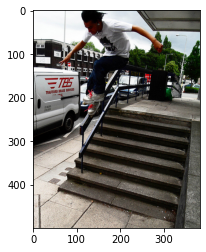

Greedy Search: a man in a black shirt and jeans is riding a unicycle on a street
Beam Search, K = 3: a man in a black shirt is riding a unicycle on a street
Beam Search, K = 5: a little boy is riding a unicycle down a street
Beam Search, K = 7: a little boy does a trick on a skateboard near a fountain
Beam Search, K = 10: a little boy does a trick on a skateboard near a fountain


In [ ]:
pic = '3702436188_2c26192fd0.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
caption = greedySearch(image)
reference = descriptions['3702436188_2c26192fd0']
print('BLEU-1:', round(sentence_bleu(reference, caption),3))

BLEU-1: 0.527


In [ ]:
c = descriptions['3702436188_2c26192fd0']

In [ ]:
print(c)

['a boy wearing a white shirt and pink shoelaces jumping on a railing', 'a man jumps of the handrail of an outdoor staircase ', 'a person on a skateboard ', 'a skateboarder is balancing on the rail of stairs ', 'a teenage boy jumps off a rail ']


In [ ]:
d = descriptions['3702436188_2c26192fd0'].append(caption)

In [ ]:
descriptions['3702436188_2c26192fd0']

['a boy wearing a white shirt and pink shoelaces jumping on a railing',
 'a man jumps of the handrail of an outdoor staircase ',
 'a person on a skateboard ',
 'a skateboarder is balancing on the rail of stairs ',
 'a teenage boy jumps off a rail ',
 'a man in a black shirt and jeans is riding a unicycle on a street']

In [ ]:
e = descriptions['3702436188_2c26192fd0']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(e)

In [ ]:
print(vectorizer.get_feature_names())
print(X.shape)

['an', 'and', 'balancing', 'black', 'boy', 'handrail', 'in', 'is', 'jeans', 'jumping', 'jumps', 'man', 'of', 'off', 'on', 'outdoor', 'person', 'pink', 'rail', 'railing', 'riding', 'shirt', 'shoelaces', 'skateboard', 'skateboarder', 'staircase', 'stairs', 'street', 'teenage', 'the', 'unicycle', 'wearing', 'white']
(6, 33)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
import pandas as pd

df = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
df

,an,and,balancing,black,boy,handrail,in,is,jeans,jumping,...,skateboard,skateboarder,staircase,stairs,street,teenage,the,unicycle,wearing,white
0,0.000000,0.283452,0.000000,0.000000,0.283452,0.000000,0.000000,0.000000,0.000000,0.345667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.345667,0.345667
1,0.338896,0.000000,0.000000,0.000000,0.000000,0.338896,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.338896,0.000000,0.000000,0.000000,0.277900,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.652057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.406839,0.000000,0.000000,0.000000,0.000000,0.333614,0.000000,0.000000,...,0.000000,0.406839,0.000000,0.406839,0.000000,0.000000,0.333614,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.409125,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.498924,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.272708,0.000000,0.332565,0.000000,0.000000,0.332565,0.272708,0.332565,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.332565,0.000000,0.000000,0.332565,0.000000,0.000000


In [ ]:
df.iloc[0,]

an              0.000000
and             0.283452
balancing       0.000000
black           0.000000
boy             0.283452
handrail        0.000000
in              0.000000
is              0.000000
jeans           0.000000
jumping         0.345667
jumps           0.000000
man             0.000000
of              0.000000
off             0.000000
on              0.205070
outdoor         0.000000
person          0.000000
pink            0.345667
rail            0.000000
railing         0.345667
riding          0.000000
shirt           0.283452
shoelaces       0.345667
skateboard      0.000000
skateboarder    0.000000
staircase       0.000000
stairs          0.000000
street          0.000000
teenage         0.000000
the             0.000000
unicycle        0.000000
wearing         0.345667
white           0.345667
Name: 0, dtype: float64

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

print(cosine_similarity(df,df))

[[1.         0.         0.07932893 0.04949581 0.11596706 0.19505855]
 [0.         1.         0.         0.27813327 0.11369568 0.07578541]
 [0.07932893 0.         1.         0.09336766 0.         0.07632212]
 [0.04949581 0.27813327 0.09336766 1.         0.13648959 0.13859878]
 [0.11596706 0.11369568 0.         0.13648959 1.         0.        ]
 [0.19505855 0.07578541 0.07632212 0.13859878 0.         1.        ]]


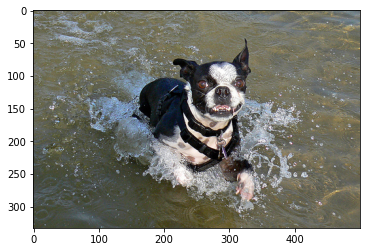

Greedy Search: a dog is running through water with a stick in its mouth
Beam Search, K = 3: a black and white dog is running through the water with a stick in its mouth
Beam Search, K = 5: a black and white dog is running through the water
Beam Search, K = 7: a black and white dog is playing with a ball in the water
Beam Search, K = 10: there is a black and white dog playing with a ball in the water


In [ ]:
pic = '1772859261_236c09b861.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
caption = greedySearch(image)
reference = descriptions['1772859261_236c09b861']
print('BLEU-1:', round(sentence_bleu(reference, caption),3))

BLEU-1: 0.502


In [ ]:
reference.append(caption)

In [ ]:
q = descriptions['1772859261_236c09b861']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
Y = vectorizer.fit_transform(q)

In [ ]:
import pandas as pd

df = pd.DataFrame(Y.toarray(),columns=vectorizer.get_feature_names())
df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,and,black,dog,harness,in,is,its,mouth,plays,running,...,splashes,stick,swims,the,through,walking,water,wearing,white,with
0,0.344050,0.344050,0.220599,0.000000,0.344050,0.000000,0.000000,0.000000,0.496957,0.000000,...,0.000000,0.000000,0.000000,0.407512,0.000000,0.000000,0.254604,0.000000,0.344050,0.000000
1,0.344050,0.344050,0.220599,0.000000,0.344050,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.407512,0.254604,0.000000,0.344050,0.000000
2,0.000000,0.000000,0.274701,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.618837,0.000000,0.000000,0.507455,0.428428,0.000000,0.317047,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.405722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.913996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.308101,0.308101,0.197550,0.445032,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.308101,0.364933,0.228002,0.445032,0.308101,0.000000
5,0.000000,0.000000,0.162981,0.000000,0.254188,0.367158,0.367158,0.367158,0.000000,0.367158,...,0.000000,0.367158,0.000000,0.000000,0.254188,0.000000,0.188105,0.000000,0.000000,0.367158


In [ ]:
df.iloc[0,]

and         0.344050
black       0.344050
dog         0.220599
harness     0.000000
in          0.344050
is          0.000000
its         0.000000
mouth       0.000000
plays       0.496957
running     0.000000
shallow     0.000000
splashes    0.000000
stick       0.000000
swims       0.000000
the         0.407512
through     0.000000
walking     0.000000
water       0.254604
wearing     0.000000
white       0.344050
with        0.000000
Name: 0, dtype: float64

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

print(cosine_similarity(df,df))

[[1.         0.58696769 0.34811427 0.08950192 0.41963595 0.17129914]
 [0.58696769 1.         0.14132028 0.08950192 0.56835043 0.17129914]
 [0.34811427 0.14132028 1.         0.11145245 0.25855376 0.21331061]
 [0.08950192 0.08950192 0.11145245 1.         0.08015027 0.06612514]
 [0.41963595 0.56835043 0.25855376 0.08015027 1.         0.15340086]
 [0.17129914 0.17129914 0.21331061 0.06612514 0.15340086 1.        ]]


In [ ]:
r = q[0]

In [ ]:
s = q[5]

In [ ]:
rouge = load_metric("rouge")
predictions = [r]
references = [s]
rouge.compute(predictions=predictions, references=references)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  """Entry point for launching an IPython kernel.


{'rouge1': AggregateScore(low=Score(precision=0.4444444444444444, recall=0.3333333333333333, fmeasure=0.380952380952381), mid=Score(precision=0.4444444444444444, recall=0.3333333333333333, fmeasure=0.380952380952381), high=Score(precision=0.4444444444444444, recall=0.3333333333333333, fmeasure=0.380952380952381)),
 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.0, recall=0.0, fmeasure=0.0), high=Score(precision=0.0, recall=0.0, fmeasure=0.0)),
 'rougeL': AggregateScore(low=Score(precision=0.3333333333333333, recall=0.25, fmeasure=0.28571428571428575), mid=Score(precision=0.3333333333333333, recall=0.25, fmeasure=0.28571428571428575), high=Score(precision=0.3333333333333333, recall=0.25, fmeasure=0.28571428571428575)),
 'rougeLsum': AggregateScore(low=Score(precision=0.3333333333333333, recall=0.25, fmeasure=0.28571428571428575), mid=Score(precision=0.3333333333333333, recall=0.25, fmeasure=0.28571428571428575), high=Score(precision=0.

In [ ]:
meteor = load_metric("meteor")
predictions1 = [r]
references1 = [s]
meteor.compute(predictions=predictions1, references=references1)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


{'meteor': 0.21367521367521372}

In [ ]:
rt = q[1]

In [ ]:
pt = q[5]

In [ ]:
rouge1 = load_metric("rouge")
predictions2 = [rt]
references2 = [pt]
rouge1.compute(predictions=predictions2, references=references2)

{'rouge1': AggregateScore(low=Score(precision=0.4444444444444444, recall=0.3333333333333333, fmeasure=0.380952380952381), mid=Score(precision=0.4444444444444444, recall=0.3333333333333333, fmeasure=0.380952380952381), high=Score(precision=0.4444444444444444, recall=0.3333333333333333, fmeasure=0.380952380952381)),
 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.0, recall=0.0, fmeasure=0.0), high=Score(precision=0.0, recall=0.0, fmeasure=0.0)),
 'rougeL': AggregateScore(low=Score(precision=0.3333333333333333, recall=0.25, fmeasure=0.28571428571428575), mid=Score(precision=0.3333333333333333, recall=0.25, fmeasure=0.28571428571428575), high=Score(precision=0.3333333333333333, recall=0.25, fmeasure=0.28571428571428575)),
 'rougeLsum': AggregateScore(low=Score(precision=0.3333333333333333, recall=0.25, fmeasure=0.28571428571428575), mid=Score(precision=0.3333333333333333, recall=0.25, fmeasure=0.28571428571428575), high=Score(precision=0.

In [ ]:
meteor = load_metric("meteor")
predictions1 = [rt]
references1 = [pt]
meteor.compute(predictions=predictions1, references=references1)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'meteor': 0.17094017094017094}

In [ ]:
qs = q[2]

In [ ]:
tr = q[5]

In [ ]:
rouge = load_metric("rouge")
predictions = [qs]
references = [tr]
rouge.compute(predictions=predictions, references=references)

{'rouge1': AggregateScore(low=Score(precision=0.6666666666666666, recall=0.3333333333333333, fmeasure=0.4444444444444444), mid=Score(precision=0.6666666666666666, recall=0.3333333333333333, fmeasure=0.4444444444444444), high=Score(precision=0.6666666666666666, recall=0.3333333333333333, fmeasure=0.4444444444444444)),
 'rouge2': AggregateScore(low=Score(precision=0.2, recall=0.09090909090909091, fmeasure=0.12500000000000003), mid=Score(precision=0.2, recall=0.09090909090909091, fmeasure=0.12500000000000003), high=Score(precision=0.2, recall=0.09090909090909091, fmeasure=0.12500000000000003)),
 'rougeL': AggregateScore(low=Score(precision=0.6666666666666666, recall=0.3333333333333333, fmeasure=0.4444444444444444), mid=Score(precision=0.6666666666666666, recall=0.3333333333333333, fmeasure=0.4444444444444444), high=Score(precision=0.6666666666666666, recall=0.3333333333333333, fmeasure=0.4444444444444444)),
 'rougeLsum': AggregateScore(low=Score(precision=0.6666666666666666, recall=0.3333

In [ ]:
meteor = load_metric("meteor")
predictions1 = [qs]
references1 = [tr]
meteor.compute(predictions=predictions1, references=references1)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'meteor': 0.17543859649122806}

In [ ]:
tn = q[3]

In [ ]:
rouge = load_metric("rouge")
predictions = [tn]
references = [tr]
rouge.compute(predictions=predictions, references=references)

{'rouge1': AggregateScore(low=Score(precision=0.6666666666666666, recall=0.16666666666666666, fmeasure=0.26666666666666666), mid=Score(precision=0.6666666666666666, recall=0.16666666666666666, fmeasure=0.26666666666666666), high=Score(precision=0.6666666666666666, recall=0.16666666666666666, fmeasure=0.26666666666666666)),
 'rouge2': AggregateScore(low=Score(precision=0.5, recall=0.09090909090909091, fmeasure=0.15384615384615385), mid=Score(precision=0.5, recall=0.09090909090909091, fmeasure=0.15384615384615385), high=Score(precision=0.5, recall=0.09090909090909091, fmeasure=0.15384615384615385)),
 'rougeL': AggregateScore(low=Score(precision=0.6666666666666666, recall=0.16666666666666666, fmeasure=0.26666666666666666), mid=Score(precision=0.6666666666666666, recall=0.16666666666666666, fmeasure=0.26666666666666666), high=Score(precision=0.6666666666666666, recall=0.16666666666666666, fmeasure=0.26666666666666666)),
 'rougeLsum': AggregateScore(low=Score(precision=0.6666666666666666, r

In [ ]:
meteor = load_metric("meteor")
predictions1 = [tn]
references1 = [tr]
meteor.compute(predictions=predictions1, references=references1)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'meteor': 0.09009009009009009}

In [ ]:
cr = q[4]

In [ ]:
rouge = load_metric("rouge")
predictions = [cr]
references = [tr]
rouge.compute(predictions=predictions, references=references)

{'rouge1': AggregateScore(low=Score(precision=0.4, recall=0.3333333333333333, fmeasure=0.3636363636363636), mid=Score(precision=0.4, recall=0.3333333333333333, fmeasure=0.3636363636363636), high=Score(precision=0.4, recall=0.3333333333333333, fmeasure=0.3636363636363636)),
 'rouge2': AggregateScore(low=Score(precision=0.1111111111111111, recall=0.09090909090909091, fmeasure=0.09999999999999999), mid=Score(precision=0.1111111111111111, recall=0.09090909090909091, fmeasure=0.09999999999999999), high=Score(precision=0.1111111111111111, recall=0.09090909090909091, fmeasure=0.09999999999999999)),
 'rougeL': AggregateScore(low=Score(precision=0.3, recall=0.25, fmeasure=0.2727272727272727), mid=Score(precision=0.3, recall=0.25, fmeasure=0.2727272727272727), high=Score(precision=0.3, recall=0.25, fmeasure=0.2727272727272727)),
 'rougeLsum': AggregateScore(low=Score(precision=0.3, recall=0.25, fmeasure=0.2727272727272727), mid=Score(precision=0.3, recall=0.25, fmeasure=0.2727272727272727), high

In [ ]:
meteor = load_metric("meteor")
predictions1 = [cr]
references1 = [tr]
meteor.compute(predictions=predictions1, references=references1)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'meteor': 0.267478813559322}

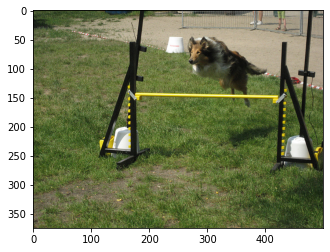

Greedy Search: a dog jumps over a bar
Beam Search, K = 3: a brown and white dog jumps over a bar
Beam Search, K = 5: a brown and white dog jumps over an obstacle course
Beam Search, K = 7: a brown and white dog jumps over an obstacle course
Beam Search, K = 10: a brown and white dog jumps over an obstacle course


In [ ]:
pic = '537559285_29be110134.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

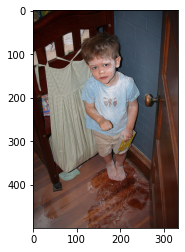

Greedy Search: a baby in a red shirt is sitting on a bed with a pacifier
Beam Search, K = 3: a baby in a red shirt is sitting on a bed
Beam Search, K = 5: a little boy in a red shirt is sitting on a bed next to a house
Beam Search, K = 7: a little boy plays with a toy
Beam Search, K = 10: a little boy plays with a toy


In [ ]:
pic = '2706766641_a9df81969d.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

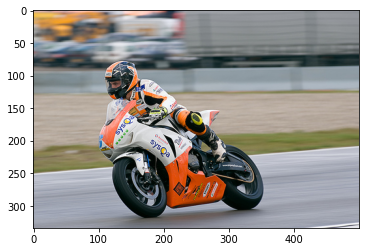

Greedy Search: a motorcycle rider is driven around a curve
Beam Search, K = 3: a motorcycle rider is riding a red motorcycle on a track
Beam Search, K = 5: a motorcycle rider rides his motorcycle around a curve
Beam Search, K = 7: a group of people racing around a curve
Beam Search, K = 10: a group of people race around a track


In [ ]:
pic = '2739331794_4ae78f69a0.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

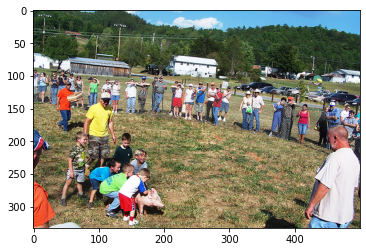

Greedy Search: a group of people are playing with a dog in a field
Beam Search, K = 3: a group of children are playing in a field of grass
Beam Search, K = 5: a group of people walk down a dirt road
Beam Search, K = 7: a group of people run down a dirt road
Beam Search, K = 10: a group of people running down a dirt road


In [ ]:
pic = '1917265421_aeccf1ca38.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

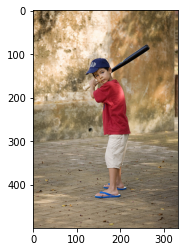

Greedy Search: a boy in a red shirt is standing in a puddle with his hands
Beam Search, K = 3: a little boy in a red shirt is standing in a puddle holding a cup
Beam Search, K = 5: a little boy in a red shirt is standing in a puddle holding a baseball bat
Beam Search, K = 7: a little boy in a red shirt is standing in a puddle holding a baseball bat
Beam Search, K = 10: there is a little boy in a striped shirt holding a bat in the air


In [ ]:
pic = '2774430374_fee1d793e7.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

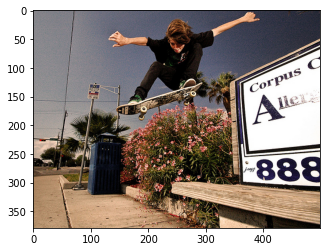

Greedy Search: a boy does a trick on a skateboard
Beam Search, K = 3: a young boy does a trick on a trampoline
Beam Search, K = 5: a young boy does a trick on a trampoline
Beam Search, K = 7: a young boy does a trick on a trampoline
Beam Search, K = 10: a boy doing a trick on a trampoline


In [ ]:
pic = '3708177171_529bb4ff1d.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

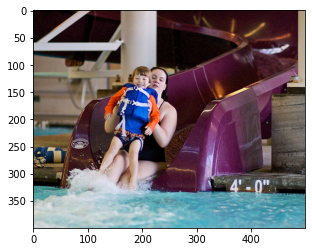

Greedy Search: a boy in a swimming pool flipping a swimming pool
Beam Search, K = 3: a young boy slides down a water slide into a pool
Beam Search, K = 5: a young boy slides down a water slide into a pool
Beam Search, K = 7: a little boy slides down a water slide into a pool
Beam Search, K = 10: a young boy slides down a water slide into a pool


In [ ]:
pic = '3030566410_393c36a6c5.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

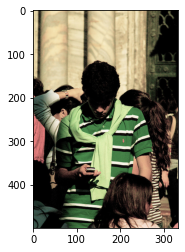

Greedy Search: a group of people are sitting in a line
Beam Search, K = 3: a group of people are sitting at a table in front of a crowd
Beam Search, K = 5: a group of people at a party
Beam Search, K = 7: a group of people at a party
Beam Search, K = 10: a group of people pose for a picture in front of a crowd


In [ ]:
pic = '421322723_3470543368.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

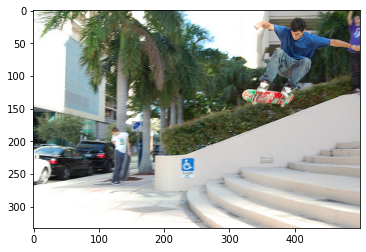

Greedy Search: a child is jumping off of a cement wall
Beam Search, K = 3: a young boy jumps off of a cement wall
Beam Search, K = 5: a little boy jumps off of a cement wall
Beam Search, K = 7: a child does a trick on a skateboard
Beam Search, K = 10: a child does a trick on a skateboard


In [ ]:
pic = '2306674172_dc07c7f847.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

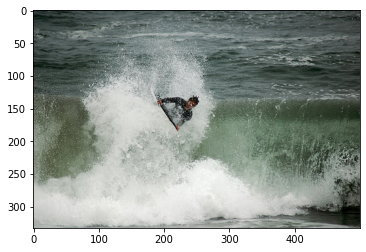

Greedy Search: a man is jumping into the water
Beam Search, K = 3: a man in a red wetsuit is surfing in the ocean
Beam Search, K = 5: a black dog jumping into the water
Beam Search, K = 7: a black dog jumping into the water
Beam Search, K = 10: a white dog is jumping into the water


In [ ]:
pic = '3631986552_944ea208fc.jpg'
image = encoding_test










[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

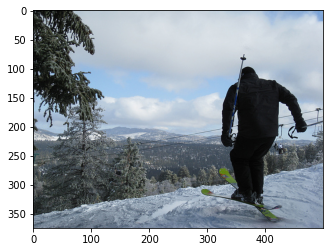

Greedy Search: a man is standing on a snowy mountain
Beam Search, K = 3: a man is standing on top of a snowy mountain
Beam Search, K = 5: a man is standing on top of a snowy mountain
Beam Search, K = 7: a man is standing on top of a snowy mountain
Beam Search, K = 10: a man is standing on top of a snowy mountain


In [ ]:
pic = '3139876823_859c7d7c23.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

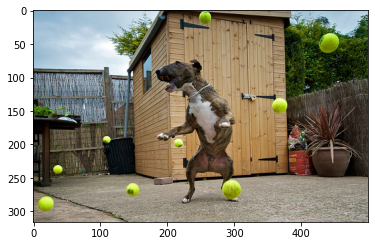

Greedy Search: a dog chases a tennis ball in a green yard
Beam Search, K = 3: a small dog chases a tennis ball in a green match
Beam Search, K = 5: a brown and white dog catches a tennis ball in a green yard
Beam Search, K = 7: a brown and white dog catches a tennis ball in a green yard
Beam Search, K = 10: a dog chases a tennis ball with a tennis ball in its mouth


In [ ]:
pic = '3490736665_38710f4b91.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

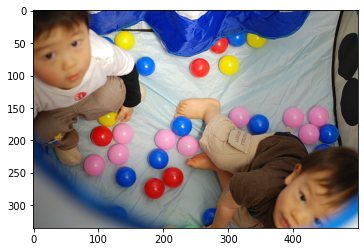

Greedy Search: a baby in a red shirt is playing with toys
Beam Search, K = 3: a baby in a red shirt plays with a toy in a house
Beam Search, K = 5: a baby in a red shirt lays on the floor surrounded by toys
Beam Search, K = 7: a little boy in a red shirt plays with a toy in a house
Beam Search, K = 10: a little boy in a red shirt plays with a toy in a house


In [ ]:
pic = '820169182_f5e78d7d19.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

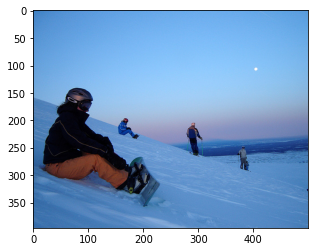

Greedy Search: a man in a red jacket is laying on a snowbank in the snow
Beam Search, K = 3: a group of people sit on a snowy hill
Beam Search, K = 5: a group of people play in the snow
Beam Search, K = 7: a group of people play in the snow in the snow
Beam Search, K = 10: a group of people play in the snow


In [ ]:
pic = '113678030_87a6a6e42e.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

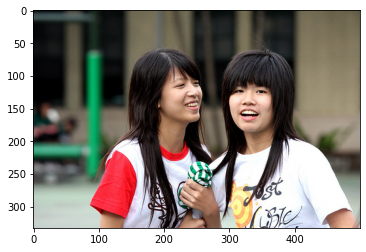

Greedy Search: a young girl in a pink shirt is smiling
Beam Search, K = 3: a woman in a black tank top holds a baby in a crowd
Beam Search, K = 5: an asian girl in a pink shirt is smiling
Beam Search, K = 7: a group of young asian girls pose for a picture
Beam Search, K = 10: a group of little girls pose for a picture


In [ ]:
pic = '3135504530_0f4130d8f8.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))